# Predict cell types

In this notebook, we leverage existing mouse gastrulation data and manually annotated cell types to predict cell type annotations for the rabbit.

Automated annotations approaches use the entire transcriptomic profile to predict cell types at a per-cell basis.

Here we used SingleR (Aran et al. 2019), an automated annotation method which uses the correlation across differentially expressed genes to determine cell type identities. Details of the method can be found [here](http://bioconductor.org/books/release/SingleRBook/).

In [1]:
library(SingleR)
library(scrabbitr)
library(scater)
library(gridExtra)
library(ggplot2)

set.seed(44)
options(repr.plot.width=18, repr.plot.height=8)

out_path <- "../data-out/celltype_annotation/"

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

In [200]:
devtools::reload(pkg = "../scrabbitr/", quiet = FALSE)


ℹ Reloading attached scrabbitr


Attaching package: ‘scrabbitr’


The following object is masked _by_ ‘.GlobalEnv’:

    plotAnnotationAlluvium




## Load data

In [2]:
# Load rabbit data
r_data <- scrabbitr::loadRabbitData("../data-in/rabbit/")
r_data

class: SingleCellExperiment 
dim: 30725 146133 
metadata(0):
assays(2): counts logcounts
rownames(30725): ENSOCUG00000014251 ENSOCUG00000005054 ...
  ENSG00000175602 ENSG00000172324
rowData names(1): V1
colnames(146133): cell_1 cell_2 ... cell_172994 cell_172995
colData names(14): cell barcode ... sizeFactor celltype
reducedDimNames(3): UMAP TSNE PCA
altExpNames(0):

In [3]:
# Load mouse data
m_data <- readRDS("../data-in/mouse/integrated_sce.rds")
m_data

class: SingleCellExperiment 
dim: 23972 430339 
metadata(0):
assays(2): counts logcounts
rownames(23972): ENSMUSG00000001138 ENSMUSG00000001143 ...
  ENSMUSG00000108929 ENSMUSG00000109022
rowData names(0):
colnames(430339): cell_1 cell_2 ... ext_cell_351871 ext_cell_351872
colData names(0):
reducedDimNames(0):
altExpNames(0):

In [4]:
m_meta <- read.table("../data-in/mouse/meta.tsv",sep="\t")
head(m_meta)

cell   sample stage stage.mapped stage.collapsed stage.mapped.collapsed
1 cell_1 1      E6.5  E6.5         E6.5            E6.5                  
2 cell_2 1      E6.5  E6.5         E6.5            E6.5                  
3 cell_5 1      E6.5  E6.5         E6.5            E6.5                  
4 cell_6 1      E6.5  E6.5         E6.5            E6.5                  
5 cell_8 1      E6.5  E6.5         E6.5            E6.5                  
6 cell_9 1      E6.5  E6.5         E6.5            E6.5                  
  somite_count tube_name    tube_name_corrected celltype        
1 Undetermined Undetermined Undetermined        Epiblast        
2 Undetermined Undetermined Undetermined        Primitive Streak
3 Undetermined Undetermined Undetermined        ExE ectoderm    
4 Undetermined Undetermined Undetermined        Epiblast        
5 Undetermined Undetermined Undetermined        Epiblast        
6 Undetermined Undetermined Undetermined        Epiblast        
  celltype.extended celltype.descendant celltype.descendant.somites
1 Epiblast          Epiblast            Epiblast                   
2 Primitive Streak  Primitive Streak    Primitive Streak           
3 ExE ectoderm      ExE ectoderm        ExE ectoderm               
4 Epiblast          Epiblast            Epiblast                   
5 Epiblast          Epiblast            Epiblast                   
6 Epiblast          Epiblast            Epiblast                   
  doub.density cluster cluster.sub celltype.clustering
1 0.0431142    7       5           Epiblast           
2 1.1297133    7       6           Primitive Streak   
3 0.1121205    1       6           ExE ectoderm       
4 1.2547088    7       2           Epiblast           
5 1.3457586    7       1           Epiblast           
6 1.1463686    7       1           Epiblast

In [5]:
m_data$celltype <- m_meta[,"celltype.clustering"]

In [6]:
# Load macaque data - Yang 2021
mf_data <- scrabbitr::loadYang2021("../data-in/datasets/Yang_2021/")

In [38]:
# Normalise macaque data
mf_clusts<- scran::quickCluster(mf_data)
mf_data <- scran::computeSumFactors(mf_data, clusters=mf_clusts)
mf_data <- scater::logNormCounts(mf_data)

In [7]:
# Load human data - Tyser 2020
hs_data <- scrabbitr::loadTyser2020("../data-in/datasets/Tyser_2020/")

In [8]:
# Load one-to-one orthologs
oc_mm_one2one <- read.table("../data-in/orthologs/mmusculus.tsv",sep="\t",col.names=c("oc","mm"))
oc_mf_one2one <- read.table("../data-in/orthologs/mfascicularis.tsv",sep="\t",header=TRUE, col.names=c("oc","mf"))
oc_hs_one2one <- read.table("../data-in/orthologs/hsapiens.tsv",sep="\t",header=TRUE, col.names=c("oc","hs"))

In [9]:
# Get rabbit, mouse, human one-to-one orthologs
library(biomaRt)

mart = useMart("ensembl", dataset = paste0("mmusculus","_gene_ensembl"))

mm_hs_homologs = getBM(attributes = c("ensembl_gene_id", "external_gene_name",
                                      paste0("hsapiens","_homolog_ensembl_gene"),
                                      paste0("hsapiens","_homolog_associated_gene_name"),
                                      paste0("hsapiens","_homolog_orthology_type")),
                       filters = "ensembl_gene_id",
                       values = rownames(m_data),
                       mart = mart)

mm_hs_one2one <- scrabbitr::filterSharedFeatures(rownames(hs_data),"hsapiens",mm_hs_homologs)
colnames(mm_hs_one2one) <- c("mm","hs")
head(mm_hs_one2one)


mm_mf_homologs = getBM(attributes = c("ensembl_gene_id", "external_gene_name",
                                      paste0("mfascicularis","_homolog_ensembl_gene"),
                                      paste0("mfascicularis","_homolog_associated_gene_name"),
                                      paste0("mfascicularis","_homolog_orthology_type")),
                       filters = "ensembl_gene_id",
                       values = rownames(m_data),
                       mart = mart)

mm_mf_one2one <- scrabbitr::filterSharedFeatures(rownames(mf_data),"mfascicularis",mm_mf_homologs)
colnames(mm_mf_one2one) <- c("mm","mf")

head(mm_hs_one2one)

mm                 hs    
1 ENSMUSG00000000037 SCML2 
2 ENSMUSG00000000134 TFE3  
3 ENSMUSG00000000194 GPR107
4 ENSMUSG00000000223 DRP2  
5 ENSMUSG00000000247 LHX2  
6 ENSMUSG00000000266 MID2

mm                 hs    
1 ENSMUSG00000000037 SCML2 
2 ENSMUSG00000000134 TFE3  
3 ENSMUSG00000000194 GPR107
4 ENSMUSG00000000223 DRP2  
5 ENSMUSG00000000247 LHX2  
6 ENSMUSG00000000266 MID2

## Predicting cell types in the rabbit

In [ ]:
m_train <- trainSingleR(ref = m_data[rm_one2one$query,],
                              labels = m_data$celltype,
                              de.method = "wilcox",
                              de.n = 50,
                              aggr.ref = TRUE)

saveRDS(model_train,paste0(out_path,"mouse_trained_aggr.rds"))

In [ ]:
# Load pre-trained model
m_train <- readRDS(paste0(out_path,"mouse_trained_aggr.rds"))

In [ ]:
r_predict <- classifySingleR(test = r_data[rm_one2one$ref,],
                                 trained = m_train)

saveRDS(r_predict,paste0(out_path,"singler_rabbit_predicted.rds"))

## Predicting cell types in macaque

In [ ]:
# Temp
mf_clusts <- scran::quickCluster(mf_data) 
mf_data <- scran::computeSumFactors(mf_data, cluster=mf_clusts, min.mean=0.1)
mf_data <- scater::logNormCounts(mf_data)


### Training on mouse and rabbit data

In [34]:
# Get one-to-one orthologs across species
oc_mm_mf_one2one <- merge(oc_mf_one2one, mm_mf_one2one,by="mf")
head(oc_mm_mf_one2one)

mf                 oc                 mm                
1 ENSMFAG00000000025 ENSOCUG00000007927 ENSMUSG00000036223
2 ENSMFAG00000000028 ENSOCUG00000013009 ENSMUSG00000075478
3 ENSMFAG00000000034 ENSOCUG00000013068 ENSMUSG00000017311
4 ENSMFAG00000000037 ENSOCUG00000006469 ENSMUSG00000059923
5 ENSMFAG00000000038 ENSOCUG00000009295 ENSMUSG00000036499
6 ENSMFAG00000000039 ENSOCUG00000024446 ENSMUSG00000020644

In [35]:
# Prepare data
r_temp <- r_data[oc_mm_mf_one2one$oc,]
rownames(r_temp) <- oc_mm_mf_one2one$mf

m_temp <- m_data[oc_mm_mf_one2one$mm,]
rownames(m_temp) <- oc_mm_mf_one2one$mf

In [36]:
# Train SingleR
ocmm_train_mf <- trainSingleR(ref = list(oc=r_temp, mm=m_temp), 
    labels = list(r_data$celltype, m_data$celltype),
                             de.method = "wilcox",
                              de.n = 50,
                              aggr.ref = TRUE)
saveRDS(ocmm_train_mf,paste0(out_path,"oc_mm_train_mf.rds"))

Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 itera

In [39]:
mf_predict_ocmm <- classifySingleR(test = mf_data[oc_mm_mf_one2one$mf,],
                                 trained = ocmm_train_mf)

saveRDS(mf_predict_ocmm,paste0(out_path,"mf_predict_ocmm_train.rds"))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

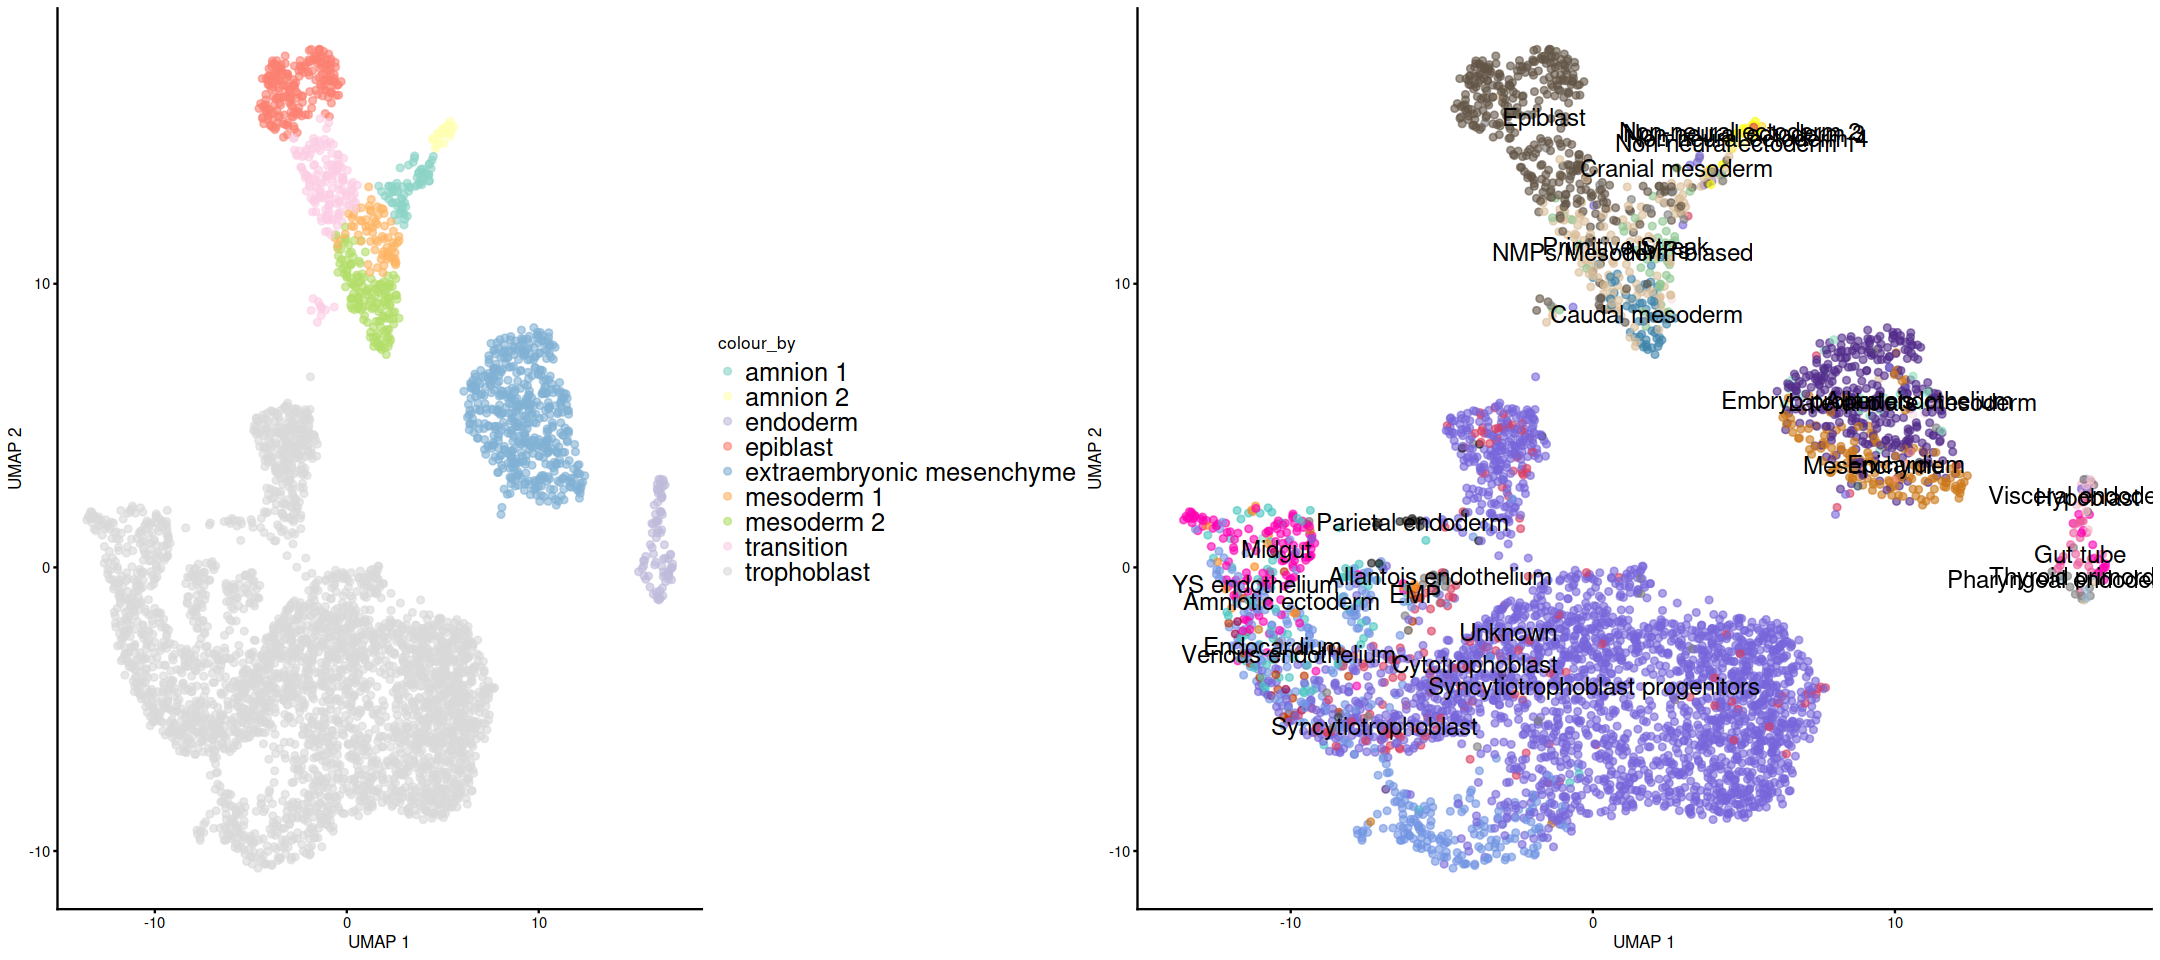

In [196]:
mf_data$predicted_celltype <- mf_predict_ocmm$orig.results$oc$pruned.labels

p1 <- plotReducedDim(mf_data[,mf_data$stage=="d14"], "UMAP", colour_by="celltype") + 
scale_colour_brewer(palette="Set3",type="qual") + 
theme(legend.text=element_text(size=15))

p2 <- plotReducedDim(mf_data[,mf_data$stage=="d14"], "UMAP", colour_by="predicted_celltype",text_by="predicted_celltype") + 
scale_colour_manual(values=scrabbitr::celltype_colours,drop=TRUE) +
theme(legend.position="none")

p <- grid.arrange(p1,p2, nrow=1)
p
#ggsave(paste0(out_path,"mf_predicted_oc_train.pdf"),p,width=15,height=6)

In [ ]:
scrabbitr::plotAnnotationAlluvium(hs_data,"celltype", "predicted_celltype",ncell_thresh=10)

### Using the mouse as a reference

In [ ]:
oc_train_mf <- trainSingleR(ref = m_data[mm_mf_one2one$oc,],
                              labels = m_data$celltype,
                              de.method = "wilcox",
                              de.n = 50,
                              aggr.ref = TRUE)

saveRDS(oc_train_mf,paste0(out_path,"oc_train_mf.rds"))

### Using the rabbit as a reference

In [ ]:
oc_train_mf <- trainSingleR(ref = r_data[oc_mf_one2one$oc,],
                              labels = r_data$celltype,
                              de.method = "wilcox",
                              de.n = 50,
                              aggr.ref = TRUE)

saveRDS(oc_train_mf,paste0(out_path,"oc_train_mf.rds"))

Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”


In [55]:
oc_train_mf <- readRDS(paste0(out_path,"oc_train_mf.rds"))

In [ ]:
mf_test <- mf_data[oc_mf_one2one$mf,]
rownames(mf_test) <- oc_mf_one2one$oc
mf_predict_oc <- classifySingleR(test = mf_test,
                                 trained = oc_train_mf)

saveRDS(mf_predict_oc,paste0(out_path,"mf_predict_oc_train.rds"))

In [62]:
mf_predict_oc <- readRDS(paste0(out_path,"mf_predict_oc_train.rds"))

In [ ]:
mf_data$predicted_celltype <- mf_predict_oc$pruned.labels

p1 <- plotReducedDim(mf_data[,mf_data$stage=="d14"], "UMAP", colour_by="celltype") + 
scale_colour_brewer(palette="Set3",type="qual") + 
theme(legend.text=element_text(size=15))

p2 <- plotReducedDim(mf_data[,mf_data$stage=="d14"], "UMAP", colour_by="predicted_celltype",text_by="predicted_celltype") + 
scale_colour_manual(values=scrabbitr::celltype_colours,drop=TRUE) +
theme(legend.position="none")

p <- grid.arrange(p1,p2, nrow=1)
p
#ggsave(paste0(out_path,"mf_predicted_oc_train.pdf"),p,width=15,height=6)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



ERROR: Error in retrieveCellInfo(se, colour_by, exprs_values = by_exprs_values, : cannot find 'predicted_celltype'


### Explore predictions

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



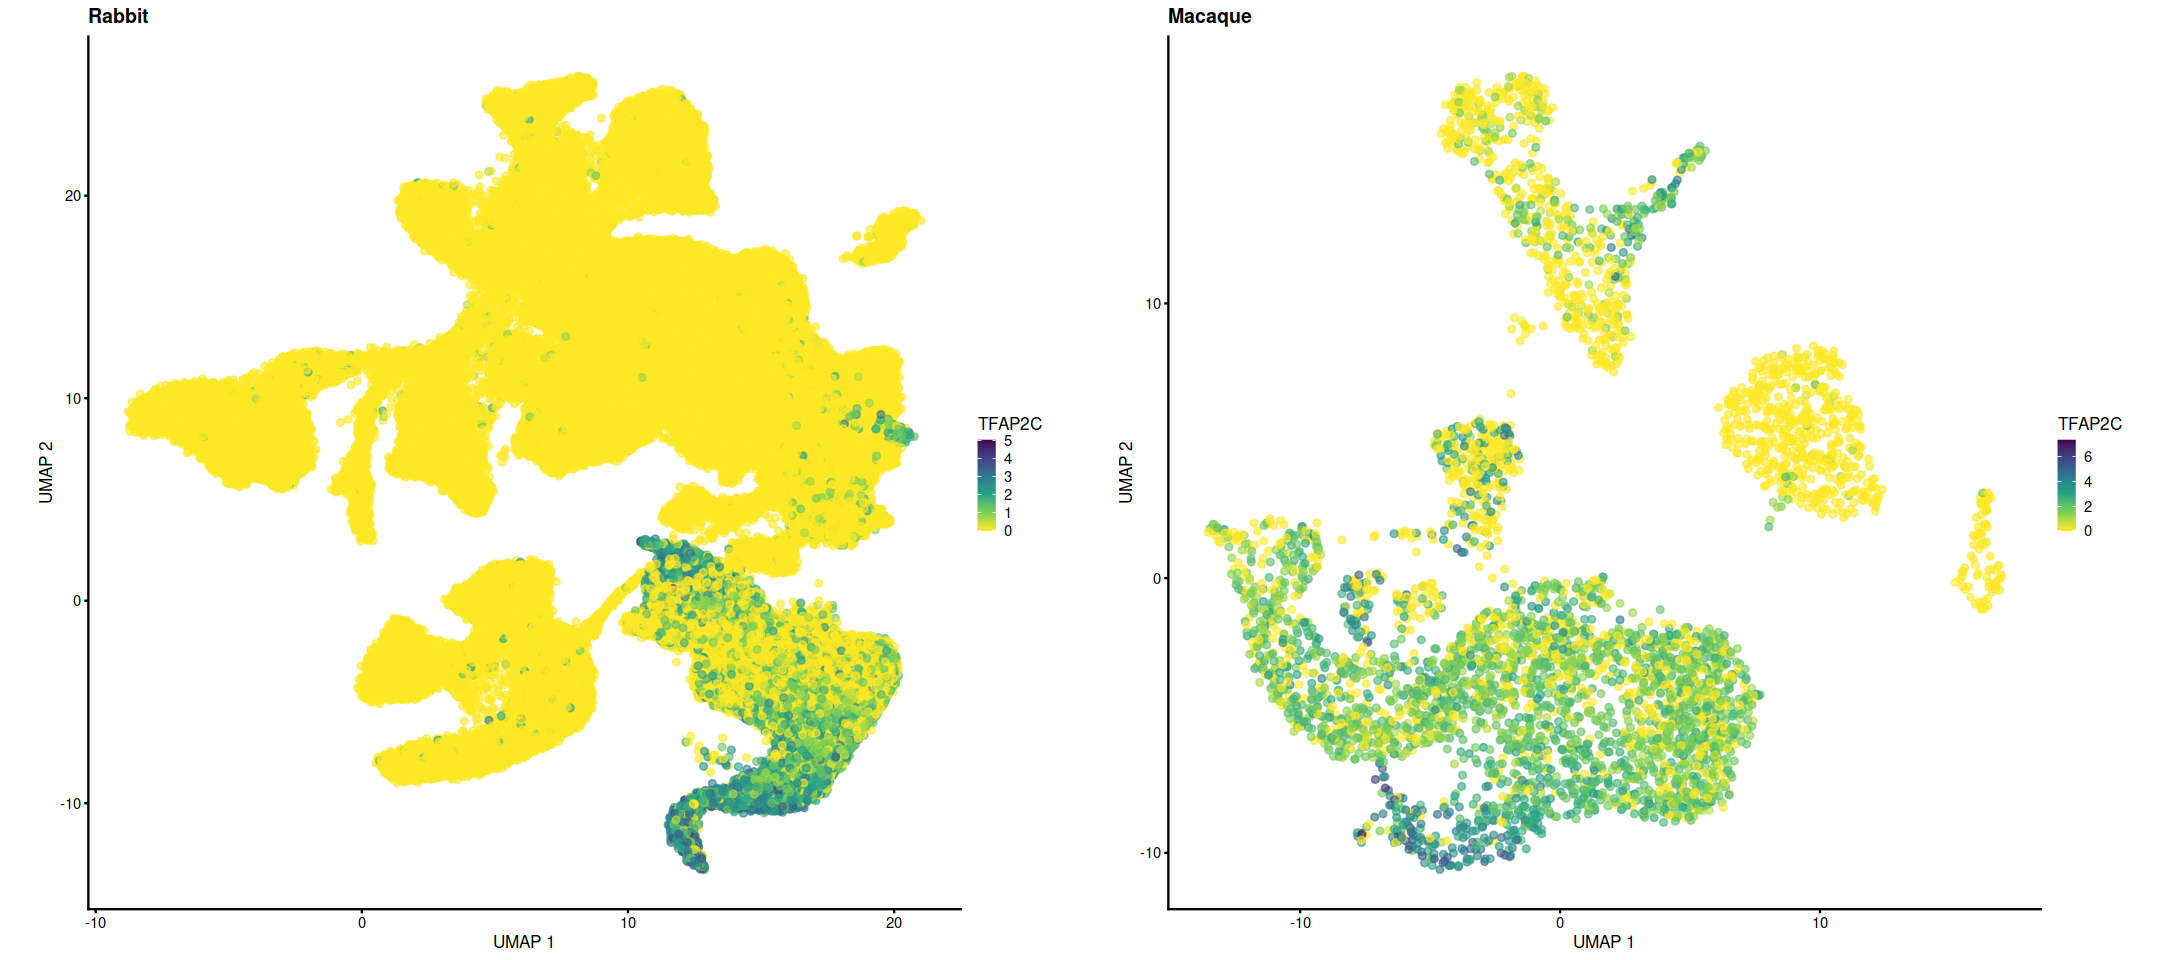

In [156]:
#ENSMFAG00000031381
#ENSMFAG00000024472
#ENSMFAG00000017477
#ENSMFAG00000004040
p2 <- plotReducedDim(mf_data[,mf_data$stage=="d14"],"UMAP", colour_by="ENSMFAG00000004040") + 
scale_colour_viridis_c(direction=-1,name="TFAP2C") + theme(aspect.ratio=1) + ggtitle("Macaque")

p1 <- plotReducedDim(r_data,"UMAP", colour_by="ENSOCUG00000010996") + 
scale_colour_viridis_c(direction=-1,name="TFAP2C") + theme(aspect.ratio=1) + ggtitle("Rabbit")

grid.arrange(p1,p2,nrow=1)


In [174]:
library(ggalluvial)
plotAnnotationAlluvium <- function(sce, old, new, ncell_thresh=10,
                                  repel_labels=TRUE, stratum_labels=FALSE,
                                  nudge=0.2) {
    
    df_frac <- aggregate(x = colnames(sce), by = list(sce[[old]],sce[[new]]), FUN = length)
    colnames(df_frac) <- c("original", "predicted", "num_cells")
    df_frac[["original"]] <- as.factor(paste0("orig_",df_frac[["original"]]))
    df_frac[["predicted"]] <- as.factor(paste0("pred_", df_frac[["predicted"]]))
    
    
    df_frac <- df_frac[df_frac$num_cells > ncell_thresh,]
    
    cols <- scrabbitr::celltype_colours
    names(cols) <- paste0("pred_",names(cols))
    
    
    p <- ggplot(df_frac,aes(axis1 = original, axis2 = predicted, y=num_cells, fill=predicted, label=predicted)) + 
        geom_alluvium() +  geom_stratum() +  
         scale_x_discrete(limits = c("Original annotation", "Predicted annotation"),
                          expand = c(.4, 0.4)) +
          geom_flow()
    
    if(repel_labels) {
        p <- p + ggrepel::geom_text_repel(
            aes(label = ifelse(substr(as.character(after_stat(stratum)), start = 1, stop = 5) == "orig_",
                               substring(as.character(after_stat(stratum)), 6) , NA)),
            stat = "stratum", size = 4, direction = "y", nudge_x = -nudge
          ) +

        ggrepel::geom_text_repel(
            aes(label = ifelse(substr(as.character(after_stat(stratum)), start = 1, stop = 5)=="pred_",
                               substring(as.character(after_stat(stratum)), 6), NA)),
            stat = "stratum", size = 4, direction = "y", nudge_x = nudge
          )
    }
    
    if(stratum_labels) {
        p <- p + geom_text(stat = "stratum",
                           aes(label = substring(as.character(after_stat(stratum)), 6)),
                           min.y=30) 
    }
    
    p <- p + theme_minimal() + 
        ylab("Number of cells") + 
        theme(
            axis.ticks.y = element_blank(),
            axis.text.y = element_blank(),
            panel.grid.major.y = element_blank(),
            panel.grid.minor.y = element_blank(),
            panel.grid.major.x = element_blank(),
            panel.background = element_blank(),
            text = element_text(size=20)
          ) +
        scale_fill_manual(values=cols) + 
        theme(legend.position = "none") 
    
    return(p)
    
}

In [198]:
p <- plotAnnotationAlluvium(mf_data[,mf_data$stage=="d14"],"celltype", "predicted_celltype",ncell_thresh=10,
                       nudge=0.45)
ggsave("../plots/predict_celltypes/Yang_2021_alluvial.pdf",p,dpi=300, width=12, height=8)

Warning message:
“Removed 17 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 8 rows containing missing values (geom_text_repel).”


## Predicting cell types in human

#### Training on mouse and rabbit data

In [10]:
# Get one-to-one orthologs across species
oc_mm_hs_one2one <- merge(oc_hs_one2one, mm_hs_one2one,by="hs")
head(oc_mm_hs_one2one)

hs      oc                 mm                
1 A1BG    ENSOCUG00000010122 ENSMUSG00000022347
2 A1CF    ENSOCUG00000011587 ENSMUSG00000052595
3 A2M     ENSOCUG00000006029 ENSMUSG00000030111
4 A3GALT2 ENSOCUG00000012461 ENSMUSG00000028794
5 A4GALT  ENSOCUG00000006673 ENSMUSG00000047878
6 A4GNT   ENSOCUG00000004002 ENSMUSG00000037953

In [11]:
# Prepare data
r_temp <- r_data[oc_mm_hs_one2one$oc,]
rownames(r_temp) <- oc_mm_hs_one2one$hs

m_temp <- m_data[oc_mm_hs_one2one$mm,]
rownames(m_temp) <- oc_mm_hs_one2one$hs

In [12]:
# Train SingleR
ocmm_train_hs <- trainSingleR(ref = list(oc=r_temp, mm=m_temp), 
    labels = list(r_data$celltype, m_data$celltype),
                             de.method = "wilcox",
                              de.n = 50,
                              aggr.ref = TRUE)
saveRDS(ocmm_train_hs,paste0(out_path,"oc_mm_train_hs.rds"))

Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 itera

In [13]:
hs_predict_ocmm <- classifySingleR(test = hs_data[oc_mm_hs_one2one$hs,],
                                 trained = ocmm_train_hs)

saveRDS(hs_predict_ocmm,paste0(out_path,"hs_predict_ocmm_train.rds"))

ERROR: Error in saveRDS(hs_predict_oc, paste0(out_path, "hs_predict_ocmm_train.rds")): object 'hs_predict_oc' not found


In [14]:
saveRDS(hs_predict_ocmm,paste0(out_path,"hs_predict_ocmm_train.rds"))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



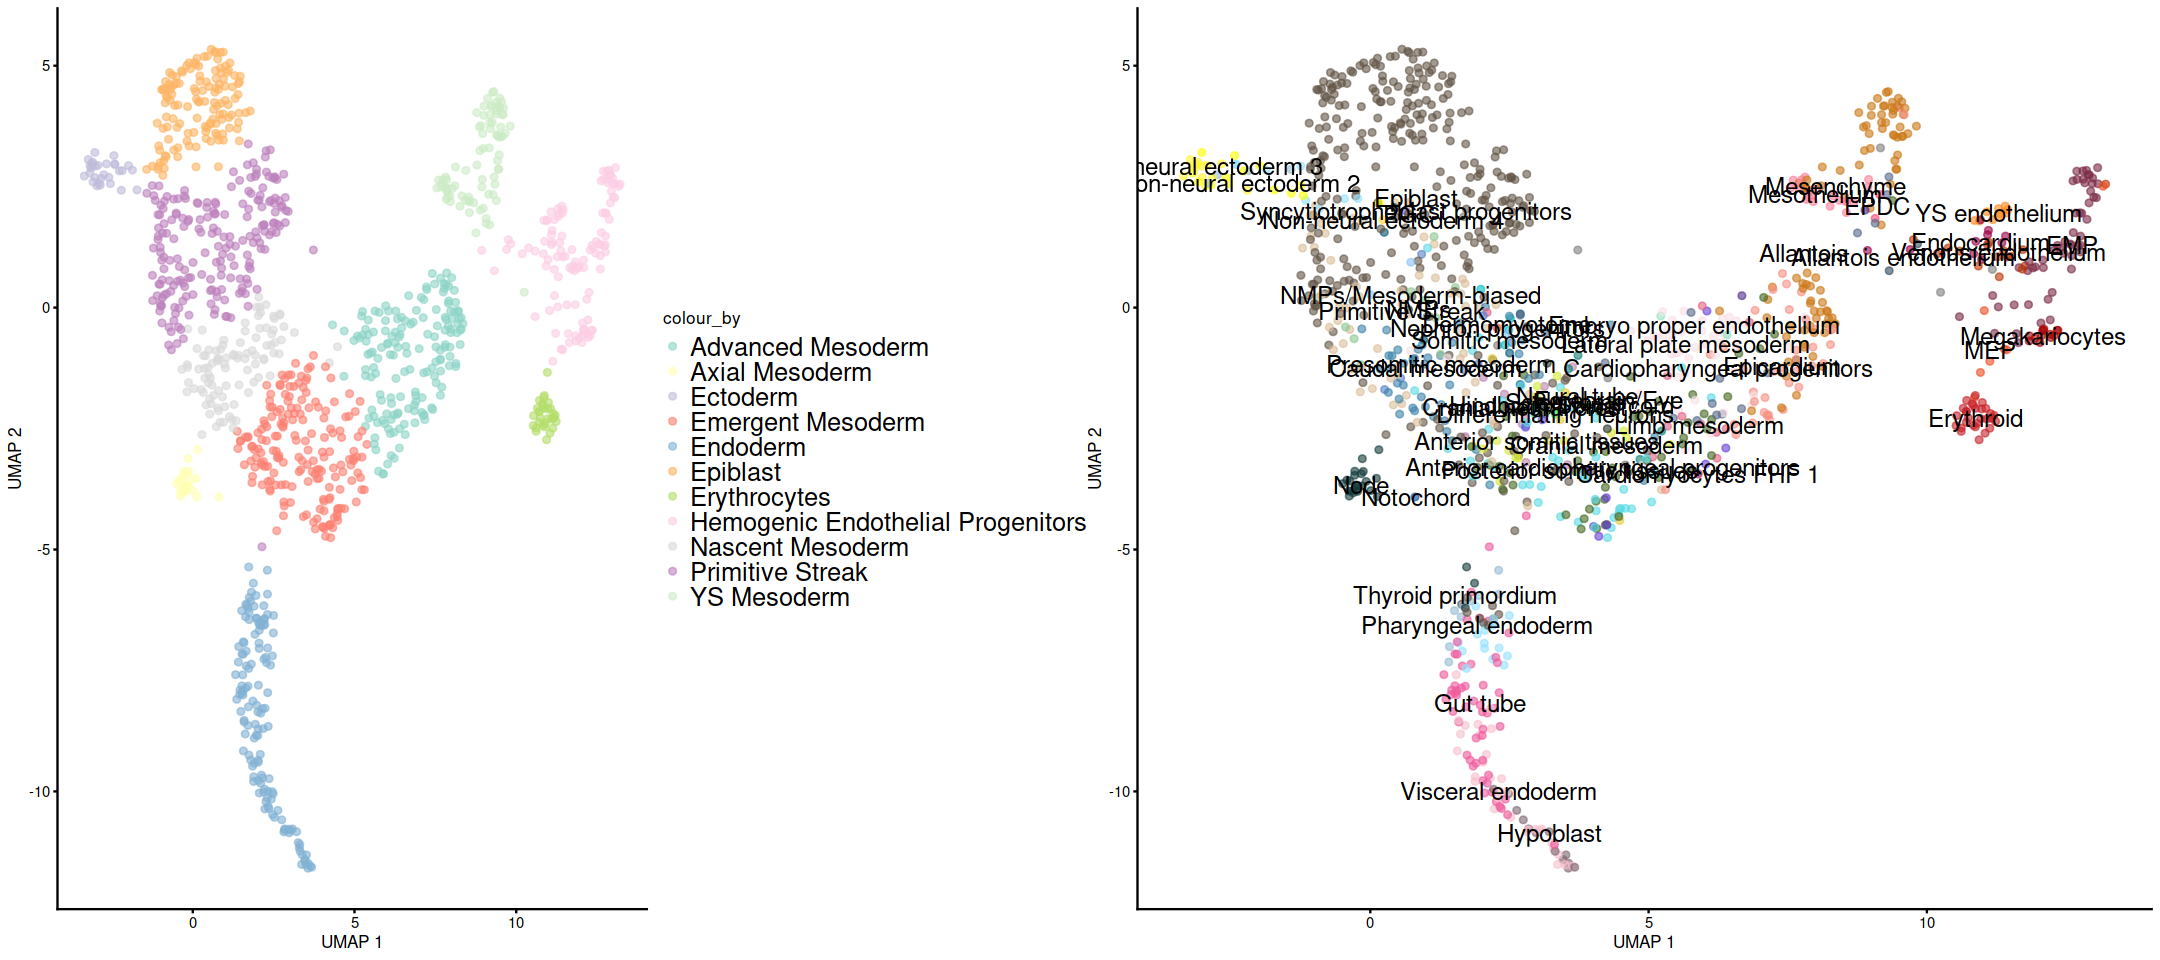

In [181]:
hs_data$predicted_celltype <- hs_predict_ocmm$orig.results$oc$pruned.labels

p1 <- plotReducedDim(hs_data, "UMAP", colour_by="celltype") + 
scale_colour_brewer(palette="Set3",type="qual") + 
theme(legend.text=element_text(size=15))

p2 <- plotReducedDim(hs_data, "UMAP", colour_by="predicted_celltype",text_by="predicted_celltype") + 
scale_colour_manual(values=scrabbitr::celltype_colours,drop=TRUE) +
theme(legend.position="none")

grid.arrange(p1,p2, nrow=1)
#ggsave(paste0(out_path,"hs_predicted_oc_train.pdf"),p,width=15,height=6)

#### Training on rabbit data

In [85]:
oc_train_hs <- trainSingleR(ref = r_data[oc_hs_one2one$oc,],
                              labels = r_data$celltype,
                              de.method = "wilcox",
                              de.n = 50,
                              aggr.ref = TRUE)

saveRDS(oc_train_hs,paste0(out_path,"oc_train_hs.rds"))

Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”


In [86]:
hs_test <- hs_data[oc_hs_one2one$hs,]
rownames(hs_test) <- oc_hs_one2one$oc
hs_predict_oc <- classifySingleR(test = hs_test,
                                 trained = oc_train_hs)

saveRDS(hs_predict_oc,paste0(out_path,"hs_predict_oc_train.rds"))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



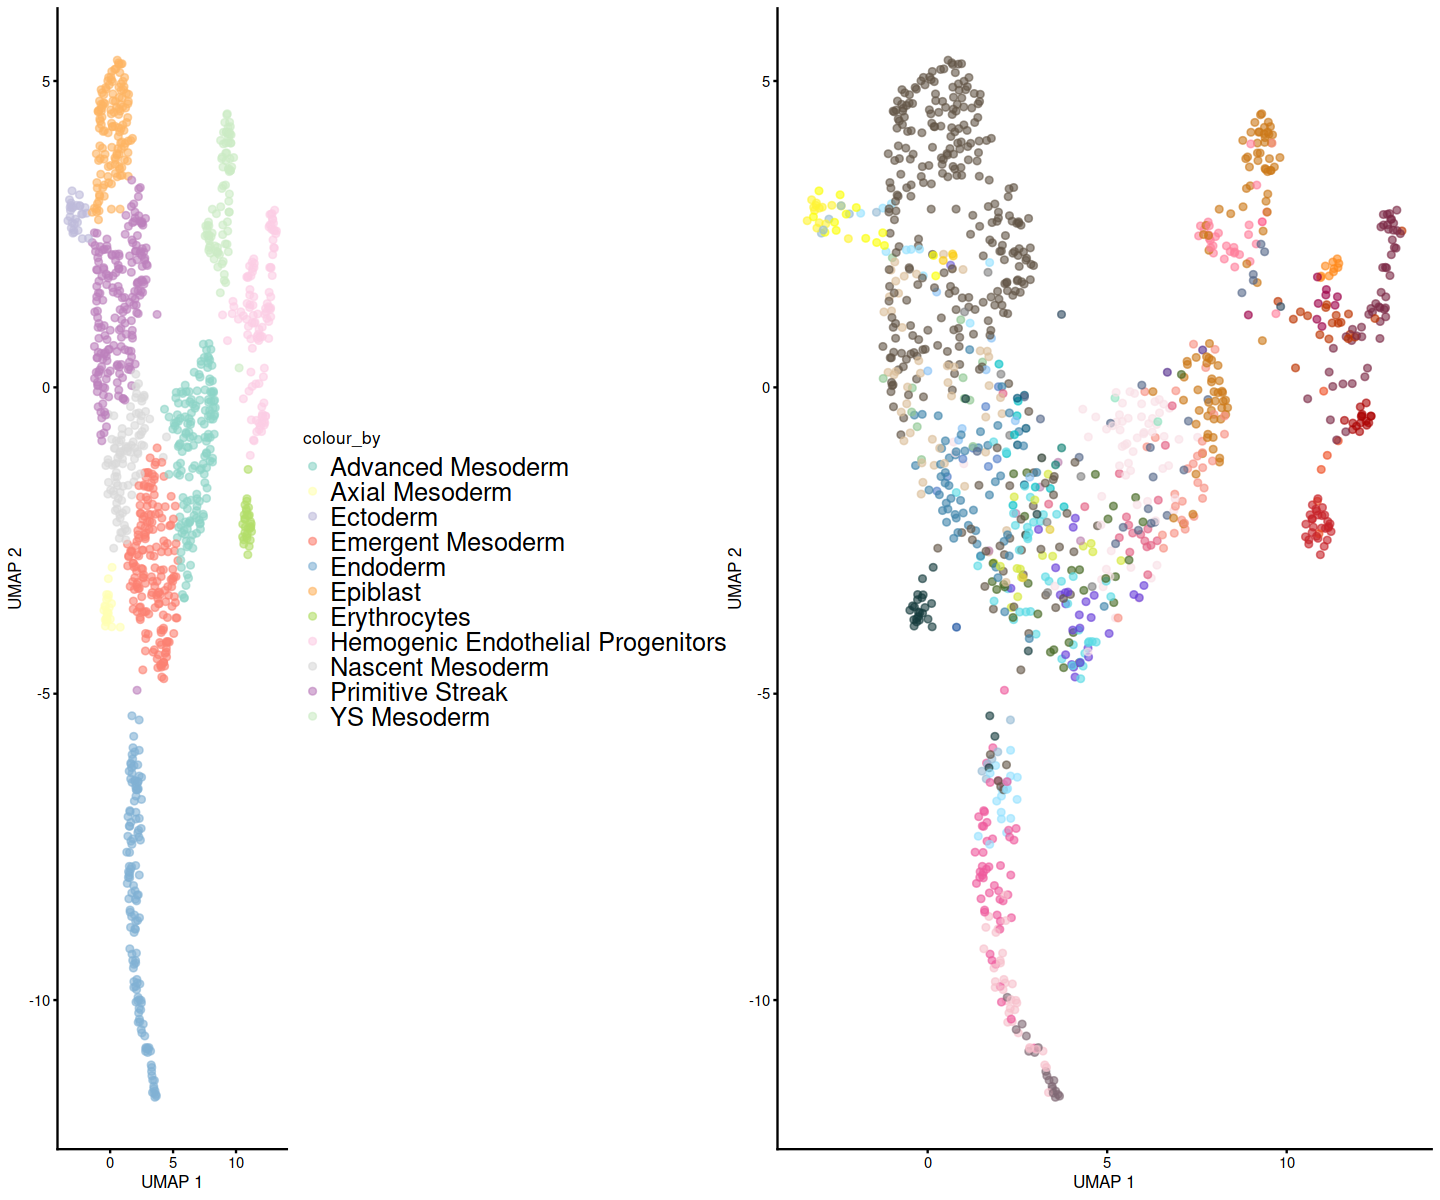

In [467]:
hs_data$predicted_celltype <- hs_predict_oc$pruned.labels

p1 <- plotReducedDim(hs_data, "UMAP", colour_by="celltype") + 
scale_colour_brewer(palette="Set3",type="qual") + 
theme(legend.text=element_text(size=15))

p2 <- plotReducedDim(hs_data, "UMAP", colour_by="predicted_celltype") + 
scale_colour_manual(values=scrabbitr::celltype_colours,drop=TRUE) +
theme(legend.position="none")

grid.arrange(p1,p2, nrow=1)
#ggsave(paste0(out_path,"hs_predicted_oc_train.pdf"),p,width=15,height=6)

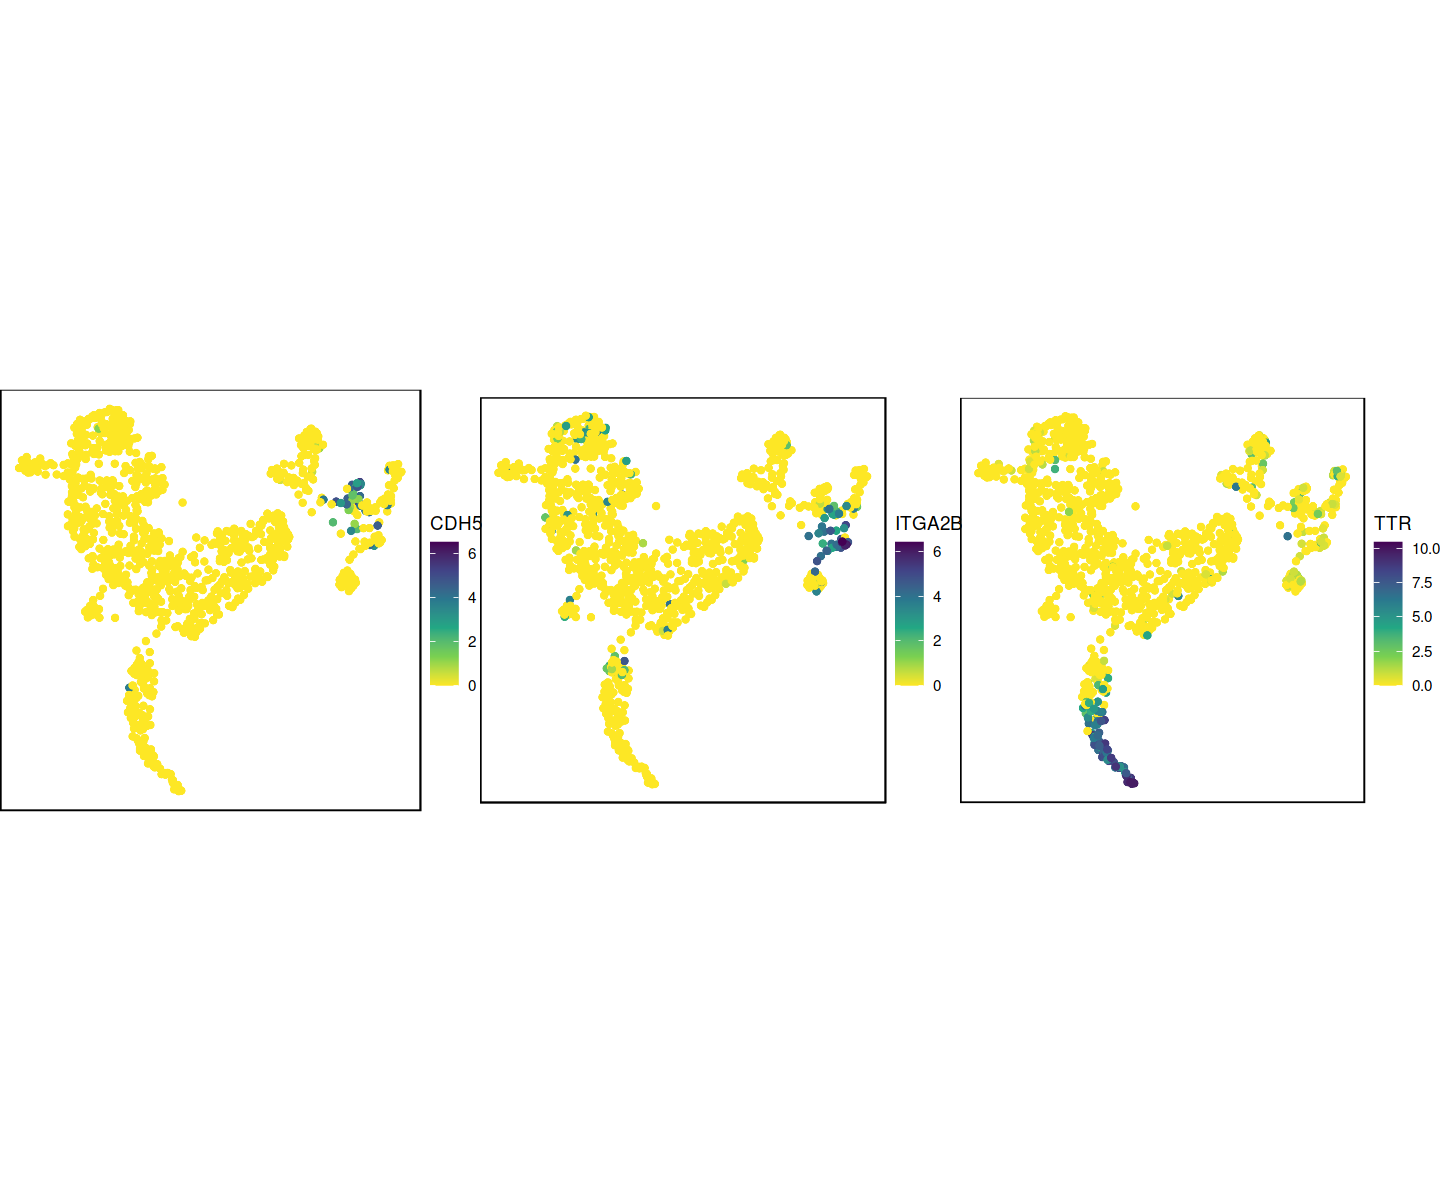

In [500]:
p1 <- ggcells(hs_data, aes_string(x="UMAP.1",y="UMAP.2",colour="CDH5")) +
ggrastr::geom_point_rast() + 
scale_color_viridis_c(direction=-1,name="CDH5") + theme_void() +
theme(axis.title = element_blank(),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          line = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5),
          panel.grid = element_blank(),
          aspect.ratio = 1) 

p2 <- ggcells(hs_data, aes_string(x="UMAP.1",y="UMAP.2",colour="ITGA2B")) +
ggrastr::geom_point_rast() + 
scale_color_viridis_c(direction=-1,name="ITGA2B") + theme_void() +
theme(axis.title = element_blank(),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          line = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5),
          panel.grid = element_blank(),
          aspect.ratio = 1) 



p3 <- ggcells(hs_data, aes_string(x="UMAP.1",y="UMAP.2",colour="TTR")) +
ggrastr::geom_point_rast() + 
scale_color_viridis_c(direction=-1,name="TTR") + theme_void() +
theme(aspect.ratio = 1) 

p <- grid.arrange(p1,p2,p3,nrow=1)
ggsave("../plots/predict_celltypes/Tyser_2020_markers.pdf",p,dpi=300, width=12, height=5)

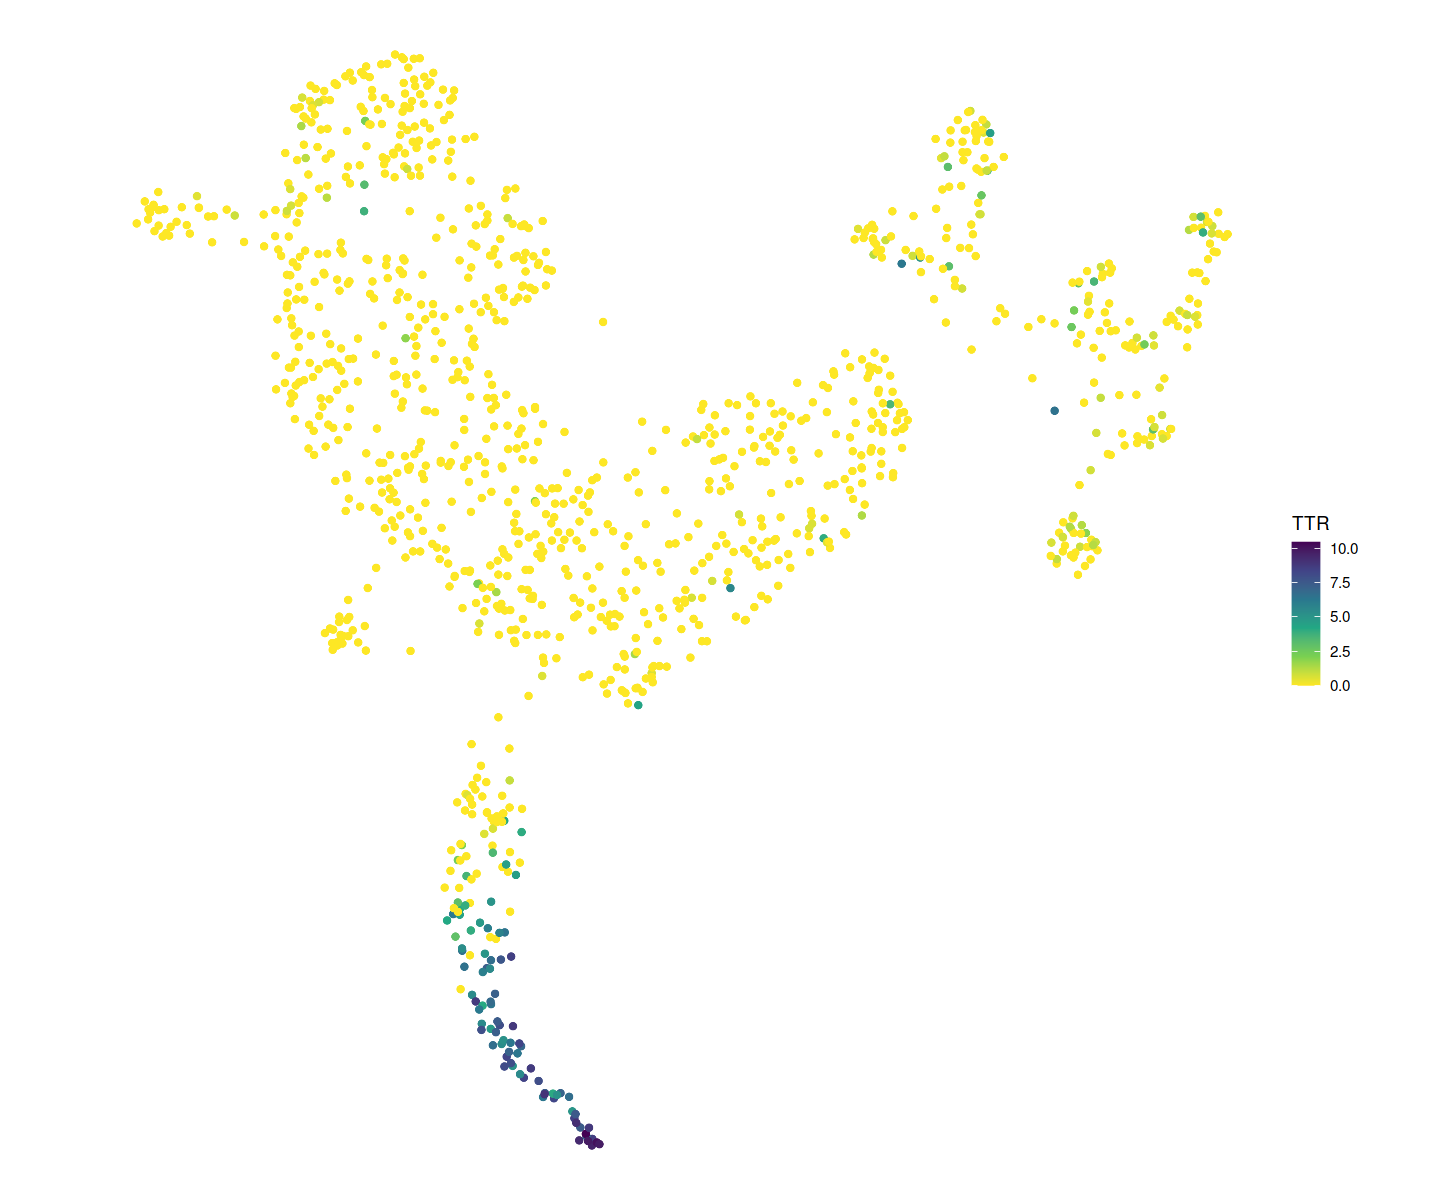

In [501]:
ggcells(hs_data, aes_string(x="UMAP.1",y="UMAP.2",colour="TTR")) +
ggrastr::geom_point_rast() + 
scale_color_viridis_c(direction=-1,name="TTR") + theme_void() +
theme(aspect.ratio = 1) 

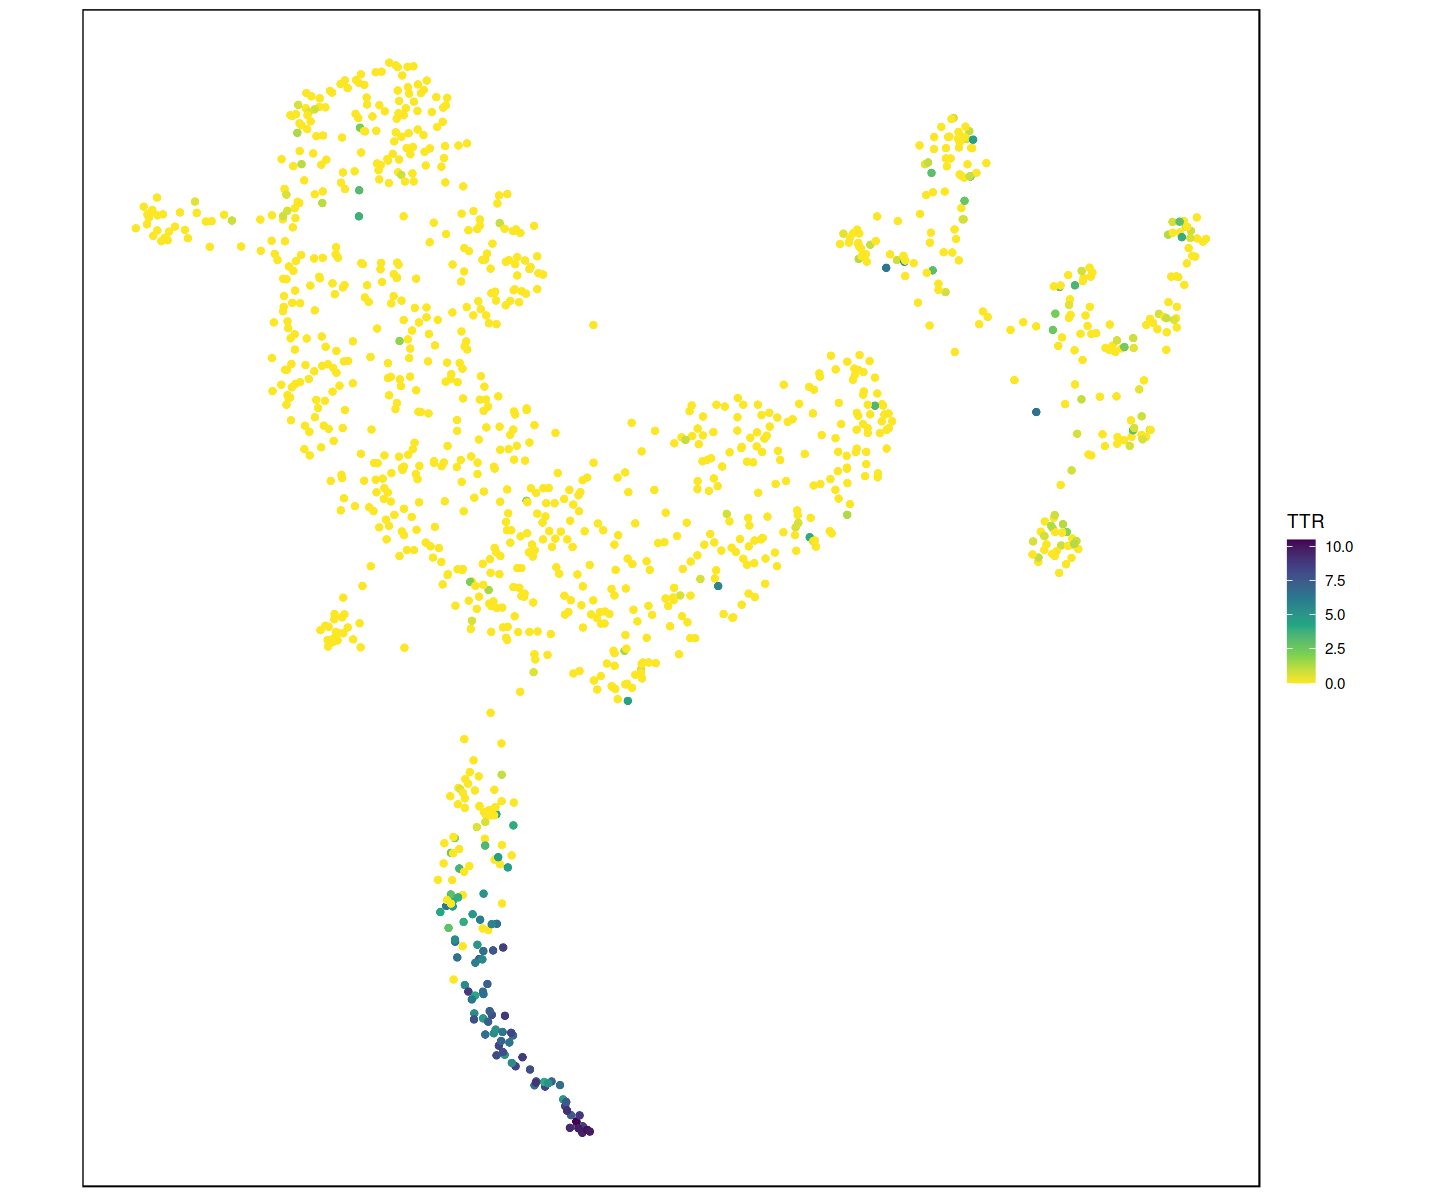

In [498]:
ggcells(hs_data, aes_string(x="UMAP.1",y="UMAP.2",colour="TTR")) +
ggrastr::geom_point_rast() + 
scale_color_viridis_c(direction=-1,name="TTR") + theme_bw() +
theme(axis.title = element_blank(),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          line = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5),
          panel.grid = element_blank(),
          aspect.ratio = 1) 

Warning message:
“Removed 20 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 11 rows containing missing values (geom_text_repel).”


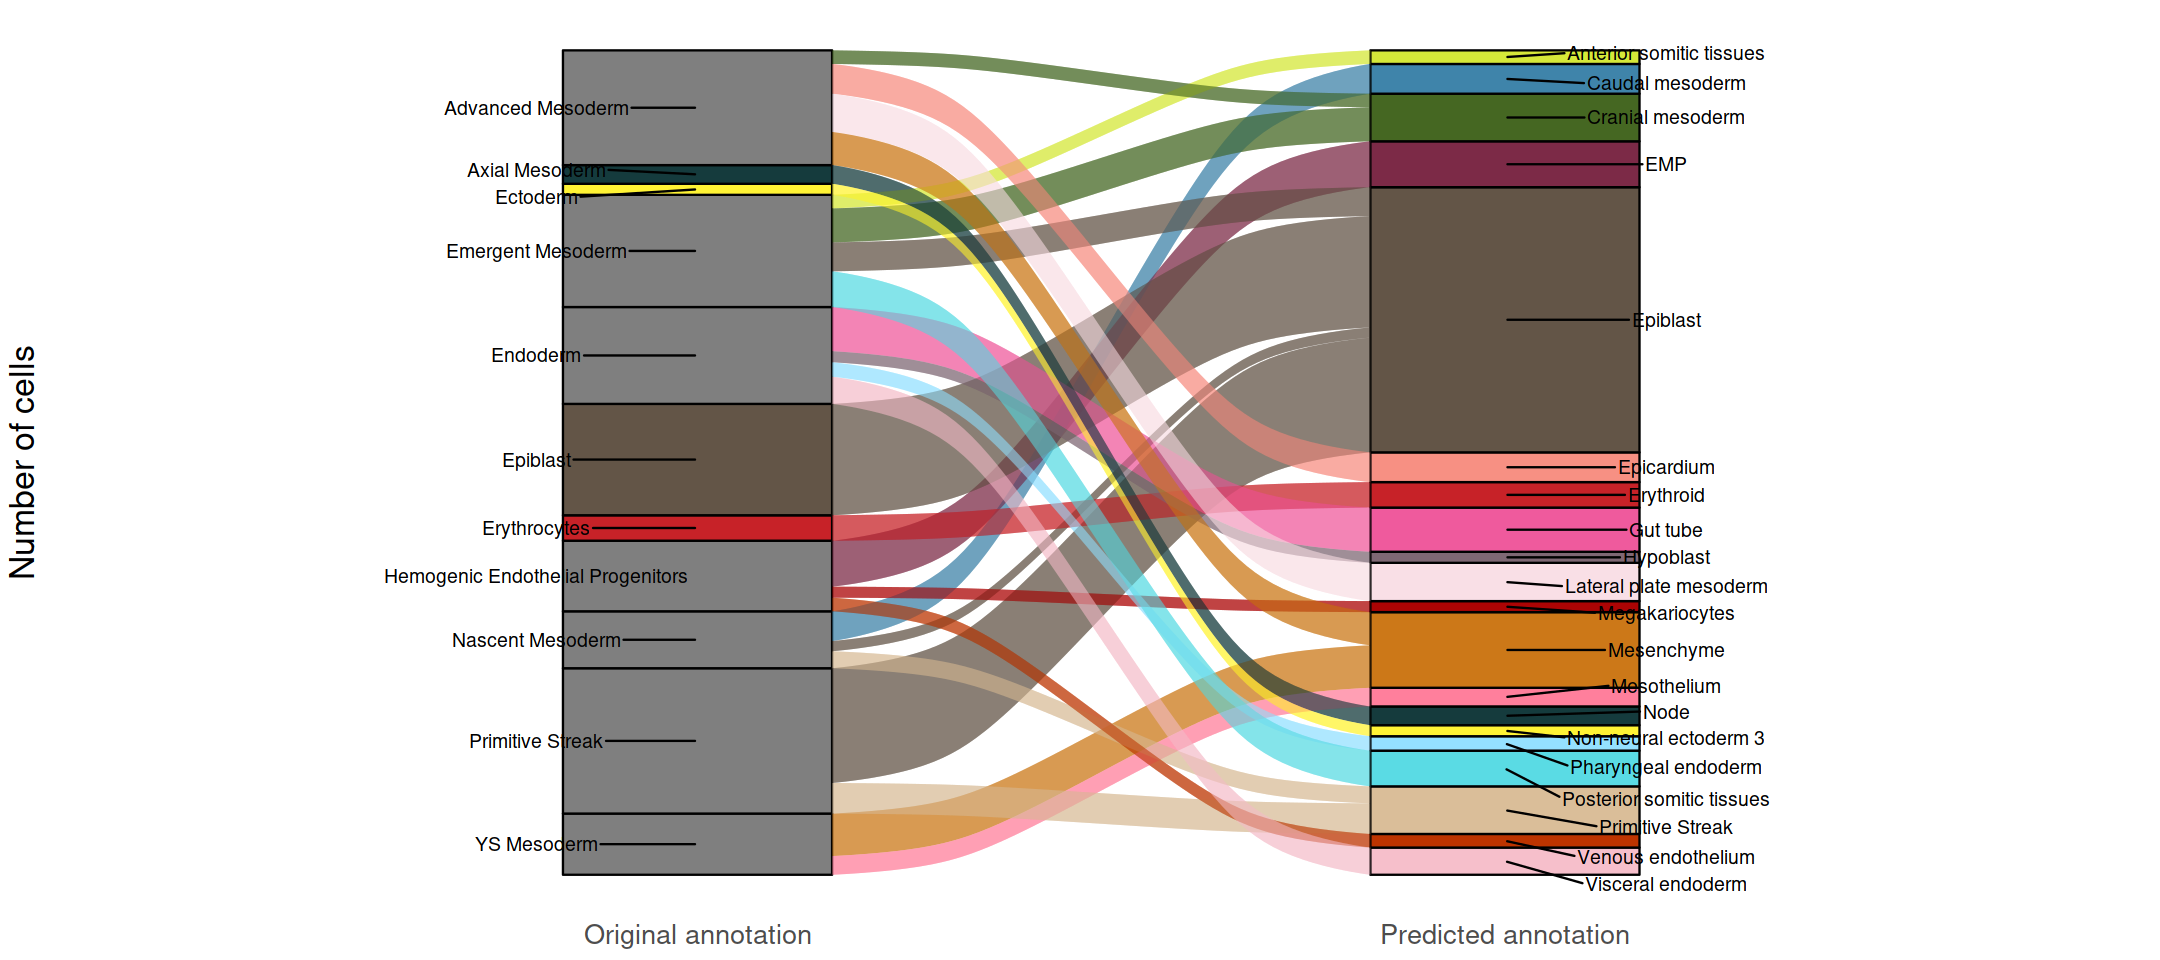

In [464]:
p <- plotAnnotationAlluvium(hs_data,"celltype", "predicted_celltype")
ggsave("../plots/predict_celltypes/Tyser_2020_alluvial.pdf",p,dpi=300, width=12, height=8)

Warning message:
“Removed 23 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 11 rows containing missing values (geom_text_repel).”


In [436]:
sub("*orig_ ", "", "orig_testststst")

[1] "orig_testststst"

In [440]:
substring("pred_tetetetsstststst", 6)

[1] "tetetetsstststst"

In [445]:
library(ggfittext)

ERROR: Error in library(ggfittext): there is no package called ‘ggfittext’
